In [140]:
import torch
from torch import nn
import torch.nn.functional as F
from datasets import load_dataset
import fastcore.all as fc
import matplotlib.pyplot as plt
import matplotlib as mpl
import torchvision.transforms.functional as TF
from torch.utils.data import default_collate, DataLoader
import torch.optim as optim
import pickle
%matplotlib inline
plt.rcParams['figure.figsize'] = [2, 2]

In [21]:
dataset_nm = 'mnist'
x,y = 'image', 'label'
ds = load_dataset(dataset_nm)

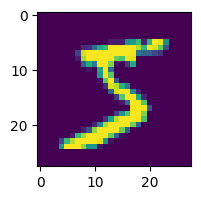

In [33]:
def transform_ds(b):
    b[x] = [TF.to_tensor(ele) for ele in b[x]]
    return b

dst = ds.with_transform(transform_ds)
plt.imshow(dst['train'][0]['image'].permute(1,2,0));

In [88]:
bs = 1024
class DataLoaders:
    def __init__(self, train_ds, valid_ds, bs, collate_fn, **kwargs):
        self.train = DataLoader(train_ds, batch_size=bs, shuffle=True, collate_fn=collate_fn, **kwargs)
        self.valid = DataLoader(train_ds, batch_size=bs*2, shuffle=False, collate_fn=collate_fn, **kwargs)

def collate_fn(b):
    collate = default_collate(b)
    return (collate[x], collate[y])

dls = DataLoaders(dst['train'], dst['test'], bs=bs, collate_fn=collate_fn)
xb,yb = next(iter(dls.train))
xb.shape, yb.shape

(torch.Size([1024, 1, 28, 28]), torch.Size([1024]))

In [120]:
class Reshape(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    
    def forward(self, x):
        return x.reshape(self.dim)

In [83]:
def cnn_classifier():
    ks,stride = 3,2
    return nn.Sequential(
        nn.Conv2d(1, 4, kernel_size=ks, stride=stride, padding=ks//2),
        nn.ReLU(),
        nn.Conv2d(4, 8, kernel_size=ks, stride=stride, padding=ks//2),
        nn.ReLU(),
        nn.Conv2d(8, 16, kernel_size=ks, stride=stride, padding=ks//2),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=ks, stride=stride, padding=ks//2),
        nn.ReLU(),
        nn.Conv2d(32, 32, kernel_size=ks, stride=stride, padding=ks//2),
        nn.ReLU(),
        nn.Conv2d(32, 10, kernel_size=ks, stride=stride, padding=ks//2),
        nn.Flatten(),
    )

In [102]:
def linear_classifier():
    return nn.Sequential(
        Reshape((-1, 784)),
        nn.Linear(784, 50),
        nn.ReLU(),
        nn.Linear(50, 50),
        nn.ReLU(),
        nn.Linear(50, 10)
    )

In [131]:
model = linear_classifier()
lr = 0.1
max_lr = 0.1
epochs = 5
opt = optim.AdamW(model.parameters(), lr=lr)
sched = optim.lr_scheduler.OneCycleLR(opt, max_lr, total_steps=len(dls.train), epochs=epochs)

for epoch in range(epochs):
    for train in (True, False):
        accuracy = 0
        dl = dls.train if train else dls.valid
        for xb,yb in dl:
            preds = model(xb)
            loss = F.cross_entropy(preds, yb)
            if train:
                loss.backward()
                opt.step()
                opt.zero_grad()
            with torch.no_grad():
                accuracy += (preds.argmax(1).detach().cpu() == yb).float().mean()
        if train:
            sched.step()
        accuracy /= len(dl)
        print(f"{'train' if train else 'eval'}, epoch:{epoch+1}, loss: {loss.item():.4f}, accuracy: {accuracy:.4f}")
    

train, epoch:1, loss: 0.3454, accuracy: 0.7909
eval, epoch:1, loss: 0.3175, accuracy: 0.9049
train, epoch:2, loss: 0.2423, accuracy: 0.9222
eval, epoch:2, loss: 0.2136, accuracy: 0.9385
train, epoch:3, loss: 0.1425, accuracy: 0.9419
eval, epoch:3, loss: 0.1797, accuracy: 0.9486
train, epoch:4, loss: 0.1427, accuracy: 0.9565
eval, epoch:4, loss: 0.1581, accuracy: 0.9624
train, epoch:5, loss: 0.1579, accuracy: 0.9620
eval, epoch:5, loss: 0.0956, accuracy: 0.9681


In [141]:
with open('linear_classifier.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)